**Here two different neural network models are used for classifying whether a person is Covid infected or not**

**The 2 models are**
1. Based on the symptoms
2. Based on the audio data of coughing of patient

## Import modules

In [57]:
import json
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf
import pandas as pd
import os
import threading as th
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Model for detection with symptoms

### Function for reading labels and features from file

In [155]:
def f(l):
  for file in l:
    if file.endswith('json'):
      f = open(file)
      d = json.load(f)
      d['id'] = file[:-5]

      data.append(d)
      f.close()

In [156]:
l = os.listdir()

n = len(l)
threads = []
for i in range(0, n, 1000):
  threads.append(th.Thread(target=f, args=(l[i:i+1000], )))

data = []

for t in threads:
  t.start()

for t in threads:
  t.join()

### Forming dataframe

In [157]:
df = pd.DataFrame(data)
df = df.fillna(np.inf)
d = df[df['expert_labels_1'] != np.inf].iloc[0]['expert_labels_1']

columns = [x for x in df.columns if x.startswith('expert')]

In [158]:
n_data = []
for row in range(df.shape[0]):
  for col in columns:
    temp = df.iloc[row][col]
    if temp != np.inf:
      n_data.append([df.iloc[row]['id']] + list(temp.values()))

### Data cleaning and preprocessing

In [159]:
nd = pd.DataFrame(n_data, columns=['id']+list(d.keys()))
df = df.merge(nd, how='outer', on='id')
df = df.drop(columns=columns)
df = df.fillna(np.inf)
df = df[df['quality'] != np.inf].drop(columns='datetime')
df = df[df['status'] != np.inf].drop(columns=['latitude', 'longitude'])

In [160]:
for col in df.columns:
  print(col, sum(df[col] == np.inf))

cough_detected 0
age 5
gender 0
respiratory_condition 0
fever_muscle_pain 0
status 0
id 0
quality 0
cough_type 0
dyspnea 0
wheezing 0
stridor 0
choking 0
congestion 0
nothing 1
diagnosis 1
severity 3


In [161]:
for col in df.columns:
  df[col][df[col] == np.inf] = np.nan

df = df.fillna(method='bfill')
df = df.set_index('id')
df = df[~df.index.duplicated(keep='first')]

In [162]:
for col in df.columns:
  l = df[col].unique()
  if len(l) < 10:
    for i, x in enumerate(l):
      df[col][df[col] == x] = i
  else:
    df[col] = np.array(df[col], dtype=np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [163]:
labels = ['healthy', 'COVID-19', 'symptomatic']

### Splitting the data

In [164]:
cols = list(df.columns)
cols.remove('status')
x, y = np.array(df[cols]).astype(np.float), np.array(df['status'])

y = np.array(pd.get_dummies(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

### Building the model

In [197]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(50, input_shape=(x_train.shape[-1], )))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dense(20))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Activation('tanh'))
model.add(keras.layers.Dense(3))
model.add(keras.layers.Activation('softmax'))

In [198]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 50)                800       
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
activation_66 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_39 (Dropout)         (None, 20)                0         
_________________________________________________________________
activation_67 (Activation)   (None, 20)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 10)              

In [199]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

### Training the model

In [200]:
model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.2475 - accuracy: 0.3485
Epoch 2/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.1449 - accuracy: 0.3788
Epoch 3/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.2101 - accuracy: 0.3788
Epoch 4/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.1330 - accuracy: 0.3788
Epoch 5/1000
3/3 [==============================] - 0s 5ms/step - loss: 1.1842 - accuracy: 0.3788
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 1.2432 - accuracy: 0.3788
Epoch 7/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.0915 - accuracy: 0.4697
Epoch 8/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.2259 - accuracy: 0.3636
Epoch 9/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.2179 - accuracy: 0.3939
Epoch 10/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.1897 - accuracy: 0.4545
Epoch 11/1000
3/3 [

### Testing the model

In [201]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 201ms/step - loss: 1.2825 - accuracy: 0.5000


[1.2824851274490356, 0.5]

# Model for detection with audio

### Function for reading audio files

In [92]:
def get_audio(l):
  for file in l:
    if os.path.isfile(file) and not(file.endswith('.json')):
      data, rate = librosa.load(file)
      audio_data.append([file, data, rate])

In [ ]:
files = os.listdir()
threads = []
audio_data = []

for i in range(0, len(files), 10):
  threads.append(th.Thread(target=get_audio, args=(files[i:i+10], )))
  threads[-1].start()

for thread in threads:
  thread.join()

In [94]:
for i, x in enumerate(audio_data):
  x[0] = x[0][:36]

### Forming dataframe from data read

In [95]:
l = list(df.index)
fil_audio_data = []
for x in audio_data:
  if x[0] in l:
    fil_audio_data.append(x+[df.loc[x[0], 'status']])

In [96]:
ad = pd.DataFrame(fil_audio_data)

### Preprocessing the data

In [97]:
def features_extractor(audio, sample_rate):
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [98]:
l = []
for i in range(ad.shape[0]):
  l.append(features_extractor(ad.iloc[i, 1], ad.iloc[i, 2]))

In [99]:
ad['features'] = l

In [101]:
X, y = np.array(ad['features']), np.array(ad[3])
y = np.array(pd.get_dummies(y))
x = X[0]
for a in X[1:]:
  x = np.vstack((x, a))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

### Building the model

In [184]:
aud_model = keras.models.Sequential()
aud_model.add(keras.layers.Dense(50, input_shape=(x_train[0].shape[0], )))
model.add(keras.layers.Dropout(0.7, ))
aud_model.add(keras.layers.Activation('relu'))
aud_model.add(keras.layers.Dense(5))
model.add(keras.layers.Dropout(0.7))
aud_model.add(keras.layers.Activation('relu'))
aud_model.add(keras.layers.Dense(10))
model.add(keras.layers.Dropout(0.7))
aud_model.add(keras.layers.Activation('relu'))
aud_model.add(keras.layers.Dense(30))
model.add(keras.layers.Dropout(0.7))
aud_model.add(keras.layers.Activation('relu'))
aud_model.add(keras.layers.Dense(3))
aud_model.add(keras.layers.Activation('softmax'))

In [185]:
aud_model.compile(loss='categorical_crossentropy', metrics='accuracy', optimizer='adam')

### Training the model

In [190]:
aud_model.fit(x_train, y_train, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7733 - accuracy: 0.6818
Epoch 2/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7709 - accuracy: 0.6818
Epoch 3/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7734 - accuracy: 0.6667
Epoch 4/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.7782 - accuracy: 0.6515
Epoch 5/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.7730 - accuracy: 0.6667
Epoch 6/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.7768 - accuracy: 0.6970
Epoch 7/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.7709 - accuracy: 0.6818
Epoch 8/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7902 - accuracy: 0.6364
Epoch 9/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.8069 - accuracy: 0.6212
Epoch 10/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.7823 - accuracy: 0.6364
Epoch 11/1000
3/3 [

### Testing the model

In [191]:
aud_model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 31ms/step - loss: 2.1805 - accuracy: 0.2500


[2.1805365085601807, 0.25]

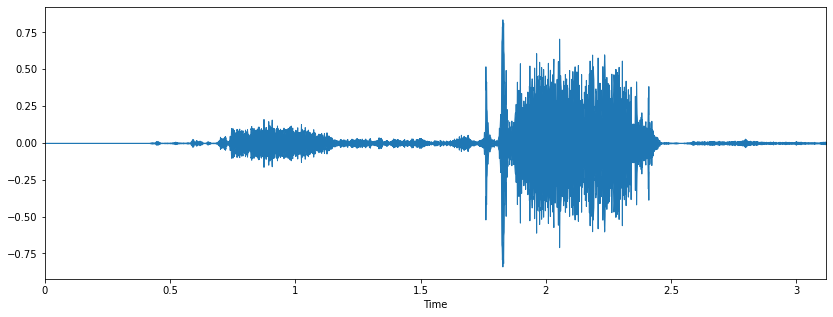

In [150]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(ad.iloc[0, 1], sr=ad.iloc[0, 2])
ipd.Audio(ad.iloc[0, 0]+".webm")